## Classifying Politicians
Your goal is to test the performance of spectral clustering and a simple semi-supervised regression algorithm on the 1984 house voting records data set. Download the data set called house-votes-84.data, and the description house-votes-84.names. The data set consists of voting records of 435 members of the House on 16 bills. There are 267 members of the democratic party and 168 members of the republican party. The voting record of each house member on the 16 bills will be our input x while the corresponding output/class 𝑦 is that members party affiliation (republican or democrat embedded as ±1).

#### Task 1

Your first task is to import and preprocess the data set. Construct your output vector y by assigning labels {−1, +1} to members of different parties. Then construct the input vectors x𝑗 corresponding to the voting records of each member by replacing ’y’ votes with +1, ’n’ votes with −1 and ’?’ with 0. You do not need to center and normalize the data set in this case. This leads to a vector y ∈ R435 and input matrix 𝑋 ∈ R435×16. Note that we are using the sklearn convention for our 𝑋 matrix.

In [181]:
import numpy as np
import matplotlib.pyplot as plt

In [182]:
votes = (np.loadtxt('house-votes-84.data', delimiter = ',', dtype =object, unpack=True)).T

In [183]:
temp_y = [item[0] for item in votes]

d = dict([(y,x+1) for x,y in enumerate(sorted(set(temp_y)))])
temp_y = [d[x] for x in temp_y]

Y = [-1 if x==2 else x for x in temp_y]
Y = np.asarray(Y)

In [184]:
temp_x = np.array([item[1:] for item in votes])

temp_x[ temp_x == '?' ] = 0 
temp_x[ temp_x == 'y' ] = 1
temp_x[ temp_x == 'n' ] = -1

#### Spectral Clustering

In [185]:
import scipy as sp
from sklearn.linear_model import Ridge
import scipy.spatial

In [186]:
# ----- define weight function from HW Task 2 description
def eta(t, l):
    val = np.exp(-(1/(2*l**2))*t**2 )
    return val

In [197]:
# ----- define clustering accuracy function
def calc_clustering_accuracy(total_data_points, comparison1, comparison2):
    difference = comparison1 - comparison2
    n_zeros = np.count_nonzero(difference==0)
    misclassified = total_data_points-n_zeros
    clustering_accuracy_ = (misclassified)/total_data_points  
    return clustering_accuracy_

In [210]:
# ----- define function to construct unnnomarlized graph Laplacian on features
def construct_graph_Laplacian(dist, l):
# -----------------------------------
# l is a hyperparameter of the Gaussian width
# alternatively, can be defined as: l = 0.05*dist.mean() # l length scale of the kernel...also hyperparameter of Guassian width
    W = eta(dist, l)
    d = np.sum(W, axis=1) # degree vector
    D = np.diag(d)
    graph_Laplacian = D - W # unnormalized graph Laplacian
    return graph_Laplacian

In [211]:
dist = sp.spatial.distance_matrix( temp_x, temp_x ) 

In [212]:
graph_Laplacian = construct_graph_Laplacian(dist, 1.25) # defined 

ll, VV = np.linalg.eigh(graph_Laplacian) # compute eigendecompositions 
idx = ll.argsort() # we need to sort the eigenvalues and vectors 
l = ll[idx]
V = VV[:, idx]

fiedler_vector = V[:,1]
sign_fiedler_vector = np.sign(V[:,1])

clustering_accuracy_ = calc_clustering_accuracy(435, sign_fiedler_vector, Y)
print(clustering_accuracy_)

0.12643678160919541


In [201]:
# plt.matshow(L[0:40,0:40])
# plt.show()

# ------------------------------------ plot eigenvalues 
# fig, ax = plt.subplots(1,1, figsize=(6,6))
# ax.plot(np.log(l[1:None]),c='navy')
# ax.set_title('Unnormalized eigenvalues')
# ax.set_xlabel('index')
# ax.set_ylabel('$\lambda$')
# plt.show()

# ------------------------------------ plot fiedler vector
# plt.scatter(np.arange(435),fiedler_vector, c='navy', s= 30, alpha=0.5)
# plt.show()

Change the parameter 𝜎 in the range (0, 4] and plot accuracy as a function of 𝜎. Let 𝜎* denote the optimal variance parameter achieving maximum clustering accuracy. Discuss your findings.

In [213]:
%%time

clustering_accuracy_w_sigma = []
sigmas = np.arange(0.01,4,0.01)

for l in sigmas:
    L = construct_graph_Laplacian(dist, l)

    ll, VV = np.linalg.eigh(L) # compute eigendecompositions 

    idx = ll.argsort() # we need to sort the eigenvalues and vectors 
    l = ll[idx]
    V = VV[:, idx]
    
    fiedler_vector = V[:,1]
    sign_fiedler_vector = np.sign(V[:,1])
    
    clustering_accuracy_ = calc_clustering_accuracy(435, sign_fiedler_vector, Y)
    clustering_accuracy_w_sigma.append(clustering_accuracy_)

CPU times: user 44.2 s, sys: 3.82 s, total: 48.1 s
Wall time: 6.25 s


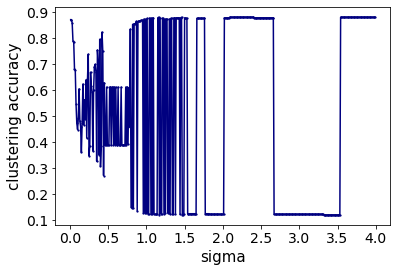

In [214]:
plt.scatter(sigmas, clustering_accuracy_w_sigma, s=1.5,c='navy')
plt.plot(sigmas, clustering_accuracy_w_sigma, c='navy')
plt.xlabel('sigma',fontsize=15)
plt.ylabel('clustering accuracy',fontsize=15)
plt.xticks(fontsize=14); plt.yticks(fontsize=14)
# plt.ylim(0,1.)
plt.show()

In [218]:
cond_1 = sigmas > 2
res = sigmas[cond_1]

print(res[np.argmax(clustering_accuracy_w_sigma)])
print(np.nanmax(clustering_accuracy_w_sigma))

3.1599999999999997
0.8804597701149425


#### Task 3 (Semi-supervised Learning)

Now consider the unnormalized Laplacian from Step 2 with the optimal parameter 𝜎* that you picked.

In [219]:
optimal_sigma = res[np.argmax(clustering_accuracy_w_sigma)]

In [242]:
L = construct_graph_Laplacian(dist, optimal_sigma)

ll, VV = np.linalg.eigh(L) # compute eigendecompositions 
idx = ll.argsort() # we need to sort the eigenvalues and vectors 
l = ll[idx]
V = VV[:, idx]

In [269]:
clustering_accuracy_list = []; new_m_list = []; new_j_list = []

for j_ in J_list:
    for m_ in M_list:
        submatrix_A = V[0:j_, 0:m_]
        b = Y[:j_]
        SSLRidge = Ridge(alpha = 1e-8)
        SSLRidge.fit(submatrix_A, b)
        
        beta = np.transpose(SSLRidge.coef_)
        A = V[:, 0:m_]
        yhat = np.sign(SSLRidge.intercept_ +  np.dot(A, beta))
        clustering_accuracy_ = calc_clustering_accuracy(435, yhat, Y)
        
        clustering_accuracy_list.append(clustering_accuracy_)
        print(m_, j_, clustering_accuracy_)
        new_m_list.append(m_)
        new_j_list.append(j_)

2 5 0.13333333333333333
3 5 0.09885057471264368
4 5 0.5793103448275863
5 5 0.5793103448275863
6 5 0.5793103448275863
2 10 0.12873563218390804
3 10 0.1425287356321839
4 10 0.08505747126436781
5 10 0.08275862068965517
6 10 0.4804597701149425
2 20 0.12413793103448276
3 20 0.09885057471264368
4 20 0.0896551724137931
5 20 0.08505747126436781
6 20 0.08505747126436781
2 40 0.12183908045977011
3 40 0.11724137931034483
4 40 0.08735632183908046
5 40 0.09425287356321839
6 40 0.09195402298850575


#### Notes from office hours
Include an explanation of constructing the similarity graph, graph Laplacians, writing about spectral clustering, how you are using the eigenvectors as your feature map, write about semi-supervised learning a bit (you have some labels but are extending it to the full dataset), talked about linear regression --> cite sources for this, no need to include the equation again but need to mention 

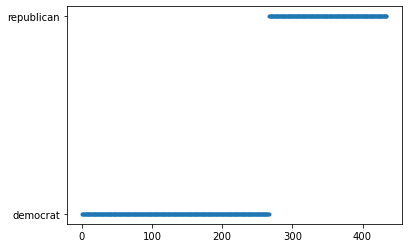

In [297]:
N = 435 
XX = votes[:, 1:None].flatten()

ind_y = np.argwhere(XX == 'y')
ind_n = np.argwhere(XX == 'n')
ind_q = np.argwhere(XX == '?')
 
XX = np.zeros(XX.shape)

XX[ind_y] = +1
XX[ind_n] = -1
XX[ind_q] = 0 

XX = XX.reshape(N,16)

YY = votes[:, 0]

ind_d = np.argwhere(YY == 'democrat')
ind_r = np.argwhere(YY == 'republican')

Y = np.append(YY[ind_d], YY[ind_r], axis=None)

plt.plot(Y,'.')
plt.show()